# Rede Convolucional e Transfer Learning

Alunos:

Israel Borges Roquete de Melo - 180033336

Gabriel Lima Sertão - 180113356



## Objetivo

Aplicar redes convolucionais pré-treinadas no problema de classificação de imagens de um conjunto de dados contendo imagens de flores, classificadas em cinco categorias, sendo elas: margaridas, dentes-de-leão, girassóis, rosas e tulipas. Além da rede VGG16, os resultados serão comparados com os resultados da classificação de uma rede de perceptron multi-camada (MLP) e outras redes convolucionais pré-treinadas. Outros parâmetros a serem experimentados são uso do _early-stopping_ para prevenir o sobreajuste dos parâmetros da rede e outras técnicas de regularizção, e teste com imagens de flores que não pertencem ao conjunto de dados obtido.




## 1. Introdução e Base de Dados

O conjunto de dados foi obtido da própria biblioteca do TensorFlow, baixado da internet no momento da execução do notebook. com 30% dos dados separados para validação do modelo, e as imagens do conjunto foram redimensionadas para 150x150 de tamanho.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
## Loading images and labels
(train_ds, train_labels), (test_ds, test_labels) = tfds.load(
    "tf_flowers",
    split=["train[:70%]", "train[:30%]"], ## Train test split
    batch_size=-1,
    as_supervised=True,  # Include labels
)

## Resizing images
train_ds = tf.image.resize(train_ds, (150, 150))
test_ds = tf.image.resize(test_ds, (150, 150))

class_labels = ["dandelion", "daisy", "tulips", "sunflowers", "roses"]

## Transforming labels to correct format
train_labels = to_categorical(train_labels, num_classes=5)
test_labels = to_categorical(test_labels, num_classes=5)




Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


## 2. Uso do MLP

Os testes iniciais de treinamento foram com o MLP, com uma camada Flatten, duas camadas densas escondidas com ativação ReLU, e uma saída com ativação softmax.

Para este modelo foi implementado o Early Stopping para evitar o sobreajuste da rede neural. De forma que, com o Early Stopping, a rede geralmente consegue apresentar uma acurácia maior, com menos tempo de treinamento, que o treinamento feito com as 50 épocas completas.

In [2]:
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(100, activation='relu')
dense_layer_2 = layers.Dense(50, activation='relu')
prediction_layer = layers.Dense(5, activation='softmax')


mlp_model = models.Sequential([
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

mlp_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=8,  restore_best_weights=True)

In [3]:

mlp_model.fit(train_ds, train_labels, epochs=50, validation_split=0.2, batch_size=32, callbacks=[es])

Epoch 1/50
65/65 [==============================] - 7s 94ms/step - loss: 219.0294 - accuracy: 0.2988 - val_loss: 116.3772 - val_accuracy: 0.2432
Epoch 2/50
65/65 [==============================] - 7s 114ms/step - loss: 59.4557 - accuracy: 0.3635 - val_loss: 81.8460 - val_accuracy: 0.3113
Epoch 3/50
65/65 [==============================] - 7s 101ms/step - loss: 45.3831 - accuracy: 0.4019 - val_loss: 40.2824 - val_accuracy: 0.3735
Epoch 4/50
65/65 [==============================] - 10s 156ms/step - loss: 26.1022 - accuracy: 0.4326 - val_loss: 34.8724 - val_accuracy: 0.3580
Epoch 5/50
65/65 [==============================] - 6s 97ms/step - loss: 16.2145 - accuracy: 0.4550 - val_loss: 24.1320 - val_accuracy: 0.3677
Epoch 6/50
65/65 [==============================] - 7s 112ms/step - loss: 15.0744 - accuracy: 0.4453 - val_loss: 25.9640 - val_accuracy: 0.3541
Epoch 7/50
65/65 [==============================] - 6s 97ms/step - loss: 8.2215 - accuracy: 0.5066 - val_loss: 13.9299 - val_accuracy: 

De qualquer forma, a acurácia no treinamento do modelo gira em torno dos 50% a 70%, enquanto os resultados ficam próximos dos 30% sem o Early Stopping.

In [4]:
# Evaluate the model on the test dataset
loss, accuracy = mlp_model.evaluate(test_ds, test_labels)

# Print the accuracy
print('Accuracy:', accuracy)

35/35 [==============================] - 1s 26ms/step - loss: 2.0225 - accuracy: 0.6857
Accuracy: 0.6857402324676514


Ao se passar o conjunto de testes para o modelo, é possível verificar a quantidade de erros comparada ao tamanho do conjunto de testes, e sua acurácia para estes testes, que então cai para em torno de 30%. O que indica que a rede continua com sobreajuste.


In [5]:

print(f"Tamanho do conjunto de testes: {test_ds.shape[0]}")
preds = tf.argmax(mlp_model(test_ds), 1)
wrong = preds != tf.argmax(test_labels, 1)
wrong, labels, wronglabels = test_ds[wrong], test_labels[wrong], preds[wrong]
print(f"Quantidade de erros: {wrong.shape[0]}\nAcurácia: {(wrong.shape[0]/test_ds.shape[0]):.3f}")

Tamanho do conjunto de testes: 1101
Quantidade de erros: 346
Acurácia: 0.314



Além disso, são mostradas abaixo algumas imagens que o modelo clssificou erroneamente e suas categorias reais preditas pelo modelo.

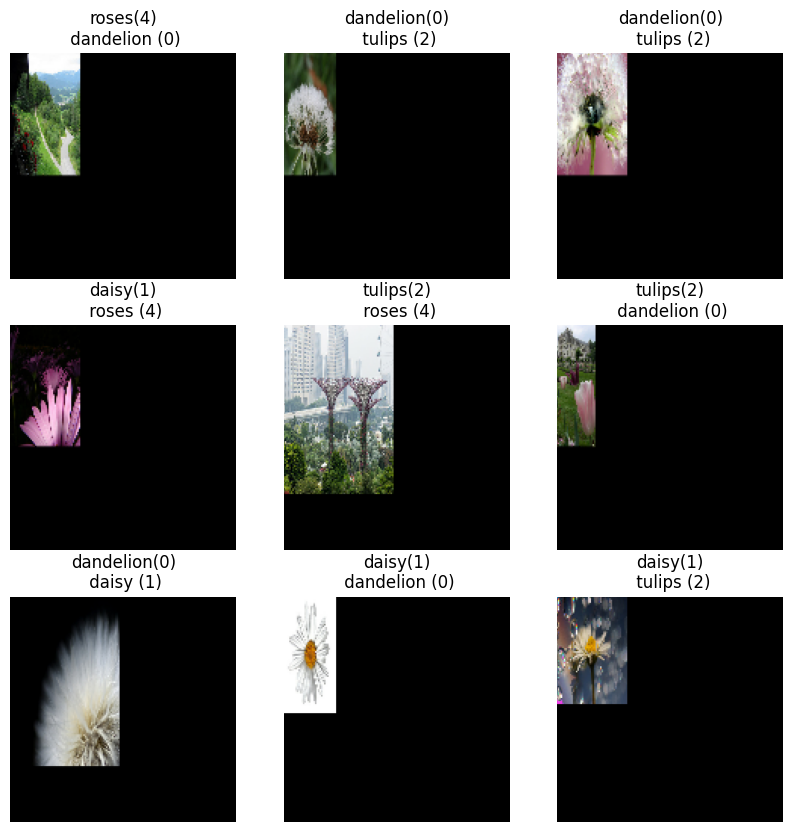

In [6]:

plt.figure(figsize=(10,10))
for idx, image in enumerate(wrong[:9]):
    plt.subplot(3,3, idx+1, )
    plt.imshow(image.numpy().astype("uint8"))
    label = tf.argmax(labels[idx], 0)
    plt.title(class_labels[label] + f"({label})\n {class_labels[wronglabels[idx]]} ({wronglabels[idx]})")
    plt.ylim(150, 0)
    plt.xlim(0, 150)
    plt.axis("off")

## 3. Uso da Rede VGG16 Pré-Treinada.

Após o teste da rede de MLP, o mesmo conjunto é passado para a rede VGG16, com fim de verificar o desempenho de uma rede pré-treinada na tarefa, com a rede sendo inserida como uma camada inicial em um modelo similar ao usado anteriormente.

In [7]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)
base_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = preprocess_input(train_ds)
test_ds = preprocess_input(test_ds)

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(100, activation='relu')
dense_layer_2 = layers.Dense(50, activation='relu')
prediction_layer = layers.Dense(5, activation='softmax')

vgg_model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

vgg_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=3,  restore_best_weights=True)

58889256/58889256 [==============================] - 0s 0us/step


In [8]:
vgg_model.fit(train_ds, train_labels, epochs=50, validation_split=0.2, batch_size=32, callbacks=[es])

Epoch 1/50
38/65 [================>.............] - ETA: 4:20 - loss: 2.4480 - accuracy: 0.4852

KeyboardInterrupt: ignored

In [ ]:
# Evaluate the model on the test dataset
loss, accuracy = mlp_model.evaluate(test_ds, test_labels)

# Print the accuracy
print('Accuracy:', accuracy)


In [ ]:
print(f"Tamanho do conjunto de testes: {test_ds.shape[0]}")
preds = tf.argmax(mlp_model(test_ds), 1)
wrong = preds != tf.argmax(test_labels, 1)
wrong, labels, wronglabels = test_ds[wrong], test_labels[wrong], preds[wrong]
print(f"Quantidade de erros: {wrong.shape[0]}\nAcurácia: {(wrong.shape[0]/test_ds.shape[0]):.3f}")

In [ ]:

plt.figure(figsize=(10,10))
for idx, image in enumerate(wrong[:9]):
    plt.subplot(3,3, idx+1, )
    plt.imshow(image.numpy().astype("uint8"))
    label = tf.argmax(labels[idx], 0)
    plt.title(class_labels[label] + f"({label})\n {class_labels[wronglabels[idx]]} ({wronglabels[idx]})")
    plt.ylim(150, 0)
    plt.xlim(0, 150)
    plt.axis("off")

## 4. Testes Adicionais



### 4.1 Outras redes convolucionais

### 4.2 Outras Técnicas de Regularização

aa




#### L1

In [ ]:
## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)
base_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = preprocess_input(train_ds)
test_ds = preprocess_input(test_ds)

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(100, activation='relu', kernel_regularizer='l1')
dense_layer_2 = layers.Dense(50, activation='relu', kernel_regularizer='l1')
prediction_layer = layers.Dense(5, activation='softmax')

vgg_model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

vgg_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

vgg_model.fit(train_ds, train_labels, epochs=50, validation_split=0.2, batch_size=32)

#### L2

In [ ]:
## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)
base_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = preprocess_input(train_ds)
test_ds = preprocess_input(test_ds)

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(100, activation='relu', kernel_regularizer='l2')
dense_layer_2 = layers.Dense(50, activation='relu', kernel_regularizer='l2')
prediction_layer = layers.Dense(5, activation='softmax')

vgg_model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

vgg_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

vgg_model.fit(train_ds, train_labels, epochs=50, validation_split=0.2, batch_size=32)

#### L3

In [ ]:
## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)
base_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = preprocess_input(train_ds)
test_ds = preprocess_input(test_ds)

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(100, activation='relu')
drop_layer_1 = layers.Dropout(0.2)
dense_layer_2 = layers.Dense(50, activation='relu')
drop_layer_2 = layers.Dropout(0.2)
prediction_layer = layers.Dense(5, activation='softmax')

vgg_model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    drop_layer_1,
    dense_layer_2,
    drop_layer_2,
    prediction_layer
])

vgg_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


vgg_model.fit(train_ds, train_labels, epochs=50, validation_split=0.2, batch_size=32)

### 4.3 Teste com Amostras que Não Fazem Parte do Conjunto de Dados Original

## Conclusão